# Example Seurat to Scanpy Conversion

This notebook shows a simple example of how a Seurat object can easily be converted to AnnData using Seurat's `convert()` functionality and [`anndata2ri`](https://github.com/flying-sheep/anndata2ri), a cool package developed by Phil Angerer.

In [1]:
import scanpy as sc
import numpy as np

import anndata2ri

To make the automatic conversion from R to python work, I activate the converter, and load rpy2.

In [2]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.3+18.g7266e67 anndata==0.6.20 umap==0.3.8 numpy==1.16.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


I am loading the Seurat clustering tutorial dataset (3k PBMCs from 10x Genomics) to demonstrate the conversion. See the [Seurat tutorial](https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html) to find instructions on how to download the dataset.

In [3]:
%%R
suppressPackageStartupMessages(library(Seurat))

# Load PBMC dataset from Seurat tutorial
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

pbmc

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features)


The loaded pbmc Seurat object has 13,714 features and 2,700 samples/observations.

Using `as.SingleCellExperiment()` I can use a Seurat function to convert the dataset to a `SingleCellExperiment` object. From there, `anndata2ri` takes care of the rest.

The only thing needed to make the final conversion from R to python here is the addition of `-o pbmc_sce` to the R-magics line. This tells `anndata2ri` to convert the dataset to AnnData, and you can continue working with it from there.

In [4]:
%%R -o pbmc_sce
#convert the Seurat object to a SingleCellExperiment object
pbmc_sce <- as.SingleCellExperiment(pbmc)

pbmc_sce

class: SingleCellExperiment 
dim: 13714 2700 
metadata(0):
assays(2): X logcounts
rownames(13714): AL627309.1 AP006222.2 ... PNRC2.1 SRSF10.1
rowData names(0):
colnames(2700): AAACATACAACCAC AAACATTGAGCTAC ... TTTGCATGAGAGGC
  TTTGCATGCCTCAC
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
spikeNames(0):


In [5]:
pbmc_sce

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident'
    layers: 'logcounts'

As you can see, the number of features and observations is correct. The order has been changed, as AnnData stores single-cell datasets according to machine learning convention, while Seurat follows the R convention. Furthermore, the metadata is all still there, and the `logcounts` assay has been stored as an AnnData layer.

# Show that the conversion worked

From here I just copy some code from the [Seurat](https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html) and [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorials to show we get the same results.

## Seurat

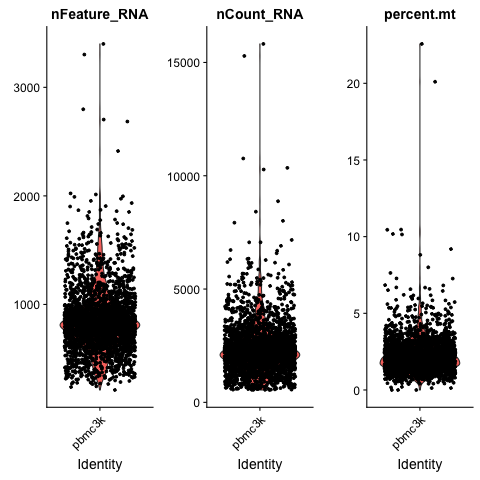

In [6]:
%%R
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

## Scanpy

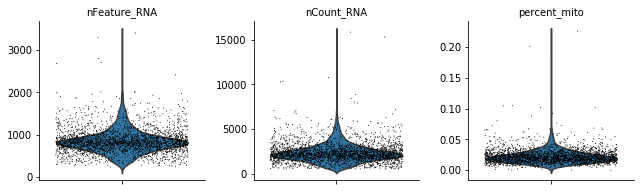

In [7]:
mito_genes = pbmc_sce.var_names.str.startswith('MT-')
pbmc_sce.obs['percent_mito'] = np.sum(pbmc_sce[:, mito_genes].X, axis=1).A1 / np.sum(pbmc_sce.X, axis=1).A1

sc.pl.violin(pbmc_sce, ['nFeature_RNA', 'nCount_RNA', 'percent_mito'], jitter=0.4, multi_panel=True)